In [239]:
%load_ext autoreload
%autoreload 2
# pull in new changes to python modules without having to restart notebook

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import control
from jsbsim_utils import Logger, trim, simulate, linearize, rootlocus, clean_tf

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Nonlinear-dynamics of aircraft

$$\dot{x} = f(x, u) \approx f(x_0, u_0) + A(x-x0) + B(u - u0)$$

Find equilibrium:

Minimize $\dot{x}$, or a subset for your problem, by changeing $x_0$, $u_0$

$$0 = f(x_0, u_0)$$

This is an optimization problem.

* Matlab: fmincon, fminsearch
* Python: scipy.minimize (Nelder-Mead, SLSQP)

Can simplify this problem with mixing matrices, to decouple the dynamcis into SISO (single-input-single output) systems.

Due to Taylor series error on the order of (dx^2). We know the linear model approx, does well near the equilibrium point. 

$\dot{\vec{x}} = \vec{f}(x, u) = A \vec{x} + B \vec{u}$

$\dot{\vec{y}} = C \vec{x} + D \vec{u}$


$A = \dfrac{\delta \vec{f}(x0, u0)}{\delta \vec{x}}$

$B = \dfrac{\delta \vec{f}(x0, u0)}{\delta \vec{u}}$

$C = \dfrac{\delta \vec{y}(x0, u0)}{\delta \vec{x}}$

$D = \dfrac{\delta \vec{y}(x0, u0)}{\delta \vec{u}}$

## Relative Stability

* Measure of relative stability. Phase margin of 90 degrees.


* sin(2*pi*f*t), where f = 10 Hz, what does a phase of 90 degrees mean -> 0.025 delay in your feedback will destabilize your system

* gain margin of 2 on pitch control -> if elevator genertes twice your predicted force, you destabilize your aircraft

# Ground Trim

In [252]:
op_ground, props = trim(
    aircraft='F-35B-2',
    ic={
        'ic/vt-fps': 0,
        'ic/psi-true-deg': 280,
        'ap/gear-enable': 1,
        'fcs/left-brake-cmd-norm': 1,
        'fcs/right-brake-cmd-norm': 1,
        'fcs/center-brake-cmd-norm': 1,
    },
    design_vector=['ic/theta-rad', 'ic/h-agl-ft'],
    x0=[0, 0],
    verbose=True,
    method='Nelder-Mead', # works better with ground interaction
    ftol=1e-2,
)
op_ground

 final_simplex: (array([[-0.01437138,  3.83414744],
       [-0.01436135,  3.83422602],
       [-0.01439668,  3.834144  ]]), array([0.00101191, 0.00102016, 0.00103319]))
           fun: 0.0010119050681570503
       message: 'Optimization terminated successfully.'
          nfev: 176
           nit: 91
        status: 0
       success: True
             x: array([-0.01437138,  3.83414744])


{'ic/vt-fps': 0,
 'ic/psi-true-deg': 280,
 'ap/gear-enable': 1,
 'fcs/left-brake-cmd-norm': 1,
 'fcs/right-brake-cmd-norm': 1,
 'fcs/center-brake-cmd-norm': 1,
 'ic/theta-rad': -0.01437138305182302,
 'ic/h-agl-ft': 3.8341474436180754}

In [253]:
log_ground = simulate(
    aircraft='F-35B-2',
    op_0=op_ground,
    tf=5,
    realtime=False)

In [27]:
props.get_property_catalog('')

AttributeError: 'dict' object has no attribute 'get_property_catalog'

## Hover Trim

In [268]:
op_hover, props = trim(
    aircraft='F-35B-2',
    ic={
        'ic/h-sl-ft': 660,
        'ic/vt-fps': 0,
        'ic/psi-true-deg': 280,
        'ap/gear-enable': 1,
    },
    eq_constraints = [
        lambda fdm: fdm['accelerations/udot-ft_sec2'],
        #lambda fdm: fdm['accelerations/vdot-ft_sec2'],
        lambda fdm: fdm['accelerations/wdot-ft_sec2'],
        #lambda fdm: fdm['accelerations/pdot-rad_sec2'],
        lambda fdm: fdm['accelerations/qdot-rad_sec2'],
        #lambda fdm: fdm['accelerations/rdot-rad_sec2'],
    ],
    design_vector=[
        'fcs/throttle-cmd-norm',
        'fcs/elevator-cmd-norm',
        'propulsion/engine/pitch-angle-rad',
        'propulsion/engine[2]/pitch-angle-rad',
    ],
    x0=[0.9, 0.1, np.deg2rad(90), np.deg2rad(90)],
    cost= lambda fdm: fdm['fcs/throttle-cmd-norm'],
    verbose=True,
    #method='SLSQP',
    bounds=[[0, 1], [-1, 1], [np.deg2rad(0), np.deg2rad(120)],[np.deg2rad(0), np.deg2rad(120)]],
)
op_hover

     fun: 0.7109874964191585
     jac: array([1., 0., 0., 0.])
 message: 'Optimization terminated successfully'
    nfev: 21
     nit: 4
    njev: 4
  status: 0
 success: True
       x: array([0.7109875 , 0.01019021, 1.57079635, 1.57079635])
constraint eq -1.2993078835066285e-15
constraint eq -1.4026113603904378e-11
constraint eq 2.5182394249231837e-12


{'ic/h-sl-ft': 660,
 'ic/vt-fps': 0,
 'ic/psi-true-deg': 280,
 'ap/gear-enable': 1,
 'fcs/throttle-cmd-norm': 0.7109874964191585,
 'fcs/elevator-cmd-norm': 0.010190213963248892,
 'propulsion/engine/pitch-angle-rad': 1.5707963492824055,
 'propulsion/engine[2]/pitch-angle-rad': 1.5707963492480337}

In [56]:
#props

In [271]:
log_hover = simulate(
    aircraft='F-35B-2',
    op_0=op_hover,
    tf=10,
    realtime=False)

KeyboardInterrupt: 

In [277]:
op_hover_auto = dict(op_hover)
op_hover_auto['ic/theta-deg'] = 0
op_hover_auto['ic/phi-deg'] = 10
op_hover_auto['ic/h-agl-ft'] = 50

op_hover_auto['ap/heading-cmd-deg'] = 280
op_hover_auto['ap/gear-enable'] = 1
op_hover_auto['ap/roll-enable'] = 1
op_hover_auto['ap/pitch-enable'] = 1
op_hover_auto['ap/yaw-enable'] = 0
op_hover_auto['ap/h-enable'] = 1
op_hover_auto['ap/h-sl-cmd-ft'] = 100

log_hover_auto = simulate(
    aircraft='F-35B-2',
    op_0=op_hover_auto,
    tf=20,
    realtime=False)

KeyboardInterrupt: 

In [246]:
log_hover_auto['fcs/throttle-pos-norm'].plot(label='0')
log_hover_auto['fcs/throttle-pos-norm[1]'].plot(label='1')
log_hover_auto['fcs/throttle-pos-norm[2]'].plot(label='2')
log_hover_auto['fcs/throttle-pos-norm[3]'].plot(label='3')

plt.legend()

NameError: name 'log_hover_auto' is not defined

<AxesSubplot:xlabel='t, sec'>

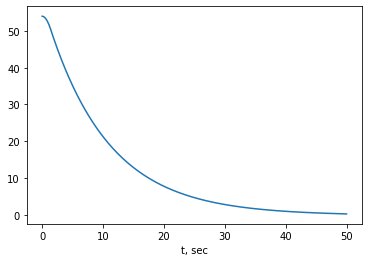

In [8]:
log_hover_auto['ap/h-error'].plot()

## Transition

In [9]:
def trim_transition(vt_fps, gamma_deg, accel_g):
    print('trimming @ Vt=', vt_fps, 'fps', 'gamma = ', gamma_deg, 'deg')
    
    def accel_gamma(fdm, accel_g, gamma_deg):
        gamma = np.deg2rad(gamma_deg)
        g = 32.2
        theta = fdm['attitude/theta-rad']
        C_nb = np.array([
            [np.cos(theta), -np.sin(theta)],
            [np.sin(theta), np.cos(theta)]
        ])
        a_n = accel_g*g*np.array([np.cos(gamma), np.sin(gamma)])
        a_b = C_nb.T.dot(a_n)
        return a_b
    
    if vt_fps < 300:
        x0 = [0.9, 0, 0, 0, np.deg2rad(90), np.deg2rad(0), 0],
    else:
        x0 = [0.9, 0, 0, 0, np.deg2rad(0), np.deg2rad(0), 0],

    op, props = trim(
        aircraft='F-35B-2',
        ic={
            'ic/h-sl-ft': 800,
            'ic/vt-fps': vt_fps,
            'ic/gamma-deg': gamma_deg,
            'ap/gear-enable': 1,
        },
        design_vector=[
            'fcs/throttle-cmd-norm',
            'fcs/elevator-cmd-norm',
            'fcs/rudder-cmd-norm',
            'fcs/aileron-cmd-norm',
            'propulsion/engine/pitch-angle-rad',
            'ic/alpha-rad',
            'ic/beta-rad',
        ],
        x0=x0,
        verbose=False,
        method='SLSQP',
        eq_constraints= [
            lambda fdm: fdm['accelerations/udot-ft_sec2'] - accel_gamma(fdm, accel_g, gamma_deg)[0],
            lambda fdm: fdm['accelerations/vdot-ft_sec2'],
            lambda fdm: fdm['accelerations/wdot-ft_sec2'] - accel_gamma(fdm, accel_g, gamma_deg)[1],
            lambda fdm: fdm['accelerations/pdot-rad_sec2'],
            lambda fdm: fdm['accelerations/qdot-rad_sec2'],
            lambda fdm: fdm['accelerations/rdot-rad_sec2'],
        ],
        cost=lambda fdm: fdm['fcs/throttle-cmd-norm'],
        bounds=[[0, 1], [-1, 1], [-1, 1], [-1, 1],
                [np.deg2rad(0), np.deg2rad(120)],
                [-0.1, 0.1], [-0.1, 0.1]],
        tol=1e-12)
    return op

ops_trim = [trim_transition(vt_fps=vt, gamma_deg=0, accel_g=0)
                  for vt in [10, 50, 100, 150, 200, 250, 300, 400, 500, 600]]
for op in ops_trim:
    print('\nvt fps', op['ic/vt-fps'])
    print('theta deg', op['ic/gamma-deg'] + np.rad2deg(op['ic/alpha-rad']))
    print('elevator', op['fcs/elevator-cmd-norm'])
    print('throttle', op['fcs/throttle-cmd-norm'])

trimming @ Vt= 10 fps gamma =  0 deg
trimming @ Vt= 50 fps gamma =  0 deg
trimming @ Vt= 100 fps gamma =  0 deg
trimming @ Vt= 150 fps gamma =  0 deg
trimming @ Vt= 200 fps gamma =  0 deg
trimming @ Vt= 250 fps gamma =  0 deg
trimming @ Vt= 300 fps gamma =  0 deg
trimming @ Vt= 400 fps gamma =  0 deg
trimming @ Vt= 500 fps gamma =  0 deg
trimming @ Vt= 600 fps gamma =  0 deg

vt fps 10
theta deg 0.6630842077816116
elevator 0.03352916963109395
throttle 0.8671969353622613

vt fps 50
theta deg 5.729577951308232
elevator 0.02912588154187861
throttle 0.8627591079955532

vt fps 100
theta deg 5.729577951308232
elevator 0.027914265581289833
throttle 0.8355302509100795

vt fps 150
theta deg 5.729577951308228
elevator 0.04522476334750385
throttle 0.7827816325785849

vt fps 200
theta deg 5.729577951308233
elevator 0.08422325538962602
throttle 0.6983592936103936

vt fps 250
theta deg 5.729577951308233
elevator 0.022227694185885286
throttle 0.5731558958847519

vt fps 300
theta deg 5.729577951308233

In [10]:
ops_transition = [trim_transition(vt_fps=vt, gamma_deg=10, accel_g=0.1)
                  for vt in [10, 50, 100, 150, 200, 250, 300, 400, 500, 600]]

ops_transition_auto = []
for op in ops_transition:
    op = dict(op)
    print('\nvt fps', op['ic/vt-fps'])
    print('theta deg', op['ic/gamma-deg'] + np.rad2deg(op['ic/alpha-rad']))
    print('elevator', op['fcs/elevator-cmd-norm'])
    print('throttle', op['fcs/throttle-cmd-norm'])
    op['ap/roll-enable'] = 1
    op['ap/pitch-enable'] = 1
    op['ap/yaw-enable'] = 1
    op['ap/h-enable'] = 0
    op['ap/h-sl-cmd-ft'] = 1000
    ops_transition_auto.append(op)

trimming @ Vt= 10 fps gamma =  10 deg
trimming @ Vt= 50 fps gamma =  10 deg
trimming @ Vt= 100 fps gamma =  10 deg
trimming @ Vt= 150 fps gamma =  10 deg
trimming @ Vt= 200 fps gamma =  10 deg
trimming @ Vt= 250 fps gamma =  10 deg
trimming @ Vt= 300 fps gamma =  10 deg
trimming @ Vt= 400 fps gamma =  10 deg
trimming @ Vt= 500 fps gamma =  10 deg
trimming @ Vt= 600 fps gamma =  10 deg

vt fps 10
theta deg 4.270422048691767
elevator 0.021883019636597046
throttle 0.8733477919612421

vt fps 50
theta deg 4.270422048691767
elevator 0.02079912101912124
throttle 0.8875853703793324

vt fps 100
theta deg 15.729577951308233
elevator -0.024363200659215628
throttle 0.8752803347392928

vt fps 150
theta deg 15.729577951308233
elevator -0.06567102087822357
throttle 0.8337169135357956

vt fps 200
theta deg 15.729577951308233
elevator -0.3543171703465902
throttle 0.7896349122923927

vt fps 250
theta deg 14.984732040819416
elevator -0.34709618948001036
throttle 0.7546353842532627

vt fps 300
theta deg 1

In [11]:
log_transition_auto = []
for op in ops_transition_auto:
    log = simulate(
        aircraft='F-35B-2',
        op_0=op,
        tf=10,
        realtime=False)
    log_transition_auto.append(log)

## Cruise Trim

In [279]:
op_cruise, props = trim(
    aircraft='F-35B-2',
    ic={
        'ic/gamma-deg': 0,
        'ic/vt-fps': 677,
        'ic/h-sl-ft': 41000,
        'gear/gear-cmd-norm': 0,
        'fcs/left-brake-cmd-norm': 0,
        'fcs/right-brake-cmd-norm': 0,
        'fcs/center-brake-cmd-norm': 0,
        'propulsion/engine/pitch-angle-rad': 0,
        'propulsion/engine[2]/pitch-angle-rad': 0,
    },
    design_vector=[
        'fcs/throttle-cmd-norm',
        'fcs/elevator-cmd-norm',
        'fcs/rudder-cmd-norm',
        'fcs/aileron-cmd-norm',
        'ic/alpha-rad',
        'ic/beta-rad',
    ],
    method='SLSQP',
    eq_constraints= [
        lambda fdm: fdm['accelerations/udot-ft_sec2'],
        lambda fdm: fdm['accelerations/vdot-ft_sec2'],
        lambda fdm: fdm['accelerations/wdot-ft_sec2'],
        lambda fdm: fdm['accelerations/pdot-rad_sec2'],
        lambda fdm: fdm['accelerations/qdot-rad_sec2'],
        lambda fdm: fdm['accelerations/rdot-rad_sec2'],
    ],
    cost=lambda fdm: fdm['fcs/throttle-cmd-norm'],
    x0=[0.5, 0, 0, 0, 0, 0],
    verbose=False,
    bounds=[[0, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1], [-1, 1]],
    tol=1e-3
)
op_cruise

RuntimeError: trim failed:
     fun: 0.2679044047449041
     jac: array([1., 0., 0., 0., 0., 0.])
 message: 'Iteration limit reached'
    nfev: 1680
     nit: 100
    njev: 100
  status: 9
 success: False
       x: array([ 0.2679044 , -0.60352492,  0.00160543,  0.00155322,  0.07125416,
        0.00077916])
{'accelerations/a-pilot-x-ft_sec2': 0.8892421536253, 'accelerations/a-pilot-y-ft_sec2': -0.09531522671409316, 'accelerations/a-pilot-z-ft_sec2': -34.38731255838274, 'accelerations/n-pilot-x-norm': 0.027638491067285106, 'accelerations/n-pilot-y-norm': -0.0029624878120923658, 'accelerations/n-pilot-z-norm': -1.0687903481612029, 'accelerations/Nx': 0.02763849429341647, 'accelerations/Ny': -0.0013560933927797994, 'accelerations/Nz': 0.9727383481687956, 'accelerations/pdot-rad_sec2': 0.03173553724703563, 'accelerations/qdot-rad_sec2': 0.15333305208123438, 'accelerations/rdot-rad_sec2': -0.002564375857022, 'accelerations/udot-ft_sec2': -1.3966875398601246, 'accelerations/vdot-ft_sec2': 0.020059018163578697, 'accelerations/wdot-ft_sec2': 0.7286370528517203, 'accelerations/gravity-ft_sec2': 32.097784995602794}

In [248]:
log_cruise = simulate(
    aircraft='F-35B-2',
    op_0=op_cruise,
    tf=5,
    realtime=False)

In [127]:
#props

In [266]:
op_cruise_auto = dict(op_cruise)
#op_cruise_auto['ic/theta-deg'] = 0
#op_cruise_auto['ic/phi-deg'] = 0
op_cruise_auto['ap/roll-enable'] = 1
op_cruise_auto['ap/pitch-enable'] = 1
op_cruise_auto['ap/yaw-enable'] = 1
op_cruise_auto['ap/h-enable'] = 1
op_cruise_auto['ap/heading-cmd-deg'] = 270
op_cruise_auto['ap/h-sl-cmd-ft'] = 45000

log_cruise_auto = simulate(
    aircraft='F-35B-2',
    op_0=op_cruise_auto,
    tf=40,
    realtime=False)

## Auto Takeoff

In [89]:
log_takeoff_auto = simulate(
    aircraft='F-35B-2',
    op_0=op_ground,
    op_list=[('hover', op_hover_auto, lambda fdm: fdm.get_sim_time() > 1),
             ('10 fps', ops_transition_auto[0], lambda fdm: fdm.get_sim_time() > 10),
             ('50 fps', ops_transition_auto[1], lambda fdm: fdm['velocities/vt-fps'] > 50),
             ('100 fps', ops_transition_auto[2], lambda fdm: fdm['velocities/vt-fps'] > 100),
             ('150 fps', ops_transition_auto[3], lambda fdm: fdm['velocities/vt-fps'] > 150),
             ('200 fps', ops_transition_auto[4], lambda fdm: fdm['velocities/vt-fps'] > 200),
             ('250 fps', ops_transition_auto[5], lambda fdm: fdm['velocities/vt-fps'] > 250),
             ('300 fps', ops_transition_auto[6], lambda fdm: fdm['velocities/vt-fps'] > 300),
             ('400 fps', ops_transition_auto[7], lambda fdm: fdm['velocities/vt-fps'] > 400),
             ('500 fps', ops_transition_auto[7], lambda fdm: fdm['velocities/vt-fps'] > 500),
             ('600 fps', ops_transition_auto[7], lambda fdm: fdm['velocities/vt-fps'] > 600),
    ],
    tf=120,
    realtime=True, verbose=True)

NameError: name 'ops_transition_auto' is not defined

# Control Design

In [217]:
sys = control.ss(*linearize(
    aircraft='F-35B-2',
    states=['ic/q-rad_sec'],
    states_deriv = ['accelerations/qdot-rad_sec2'],
    inputs=['fcs/elevator-cmd-norm'],
    outputs=['ic/q-rad_sec'],
    ic=op_hover,
    dx=1e-3,
    n_round=3
))
s = control.tf([1, 0], [1])
rad2deg = 180/np.pi
G_elev_to_pitch = rad2deg*clean_tf(control.minreal(control.ss2tf(sys), 1e-3))/s
G_elev_to_pitch

0 states have been removed from the model


TransferFunction(array([766.21645943]), array([1., 0., 0.]))

In [115]:
sys

StateSpace(array([[-0.]]), array([[13.373]]), array([[1.]]), array([[0.]]))

C:\Users\tang8\anaconda3\lib\site-packages\control\margins.py:322: RuntimeWarning: invalid value encountered in less_equal
  w_180 = w_180[w180_resp <= 0.]
C:\Users\tang8\anaconda3\lib\site-packages\control\margins.py:323: RuntimeWarning: invalid value encountered in less_equal
  w180_resp = w180_resp[w180_resp <= 0.]
C:\Users\tang8\anaconda3\lib\site-packages\control\margins.py:322: RuntimeWarning: invalid value encountered in less_equal
  w_180 = w_180[w180_resp <= 0.]
C:\Users\tang8\anaconda3\lib\site-packages\control\margins.py:323: RuntimeWarning: invalid value encountered in less_equal
  w180_resp = w180_resp[w180_resp <= 0.]
C:\Users\tang8\anaconda3\lib\site-packages\control\margins.py:322: RuntimeWarning: invalid value encountered in less_equal
  w_180 = w_180[w180_resp <= 0.]
C:\Users\tang8\anaconda3\lib\site-packages\control\margins.py:323: RuntimeWarning: invalid value encountered in less_equal
  w180_resp = w180_resp[w180_resp <= 0.]


(inf, 90.16505534604596, nan, 195.4236047470444)

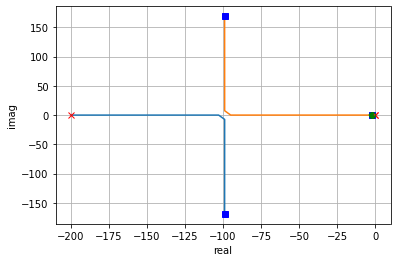

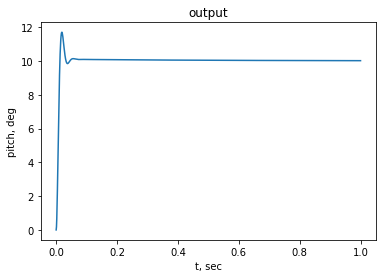

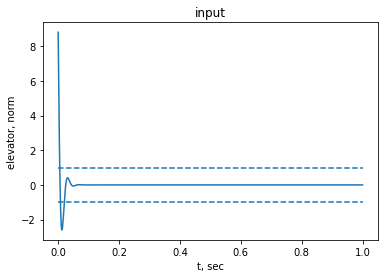

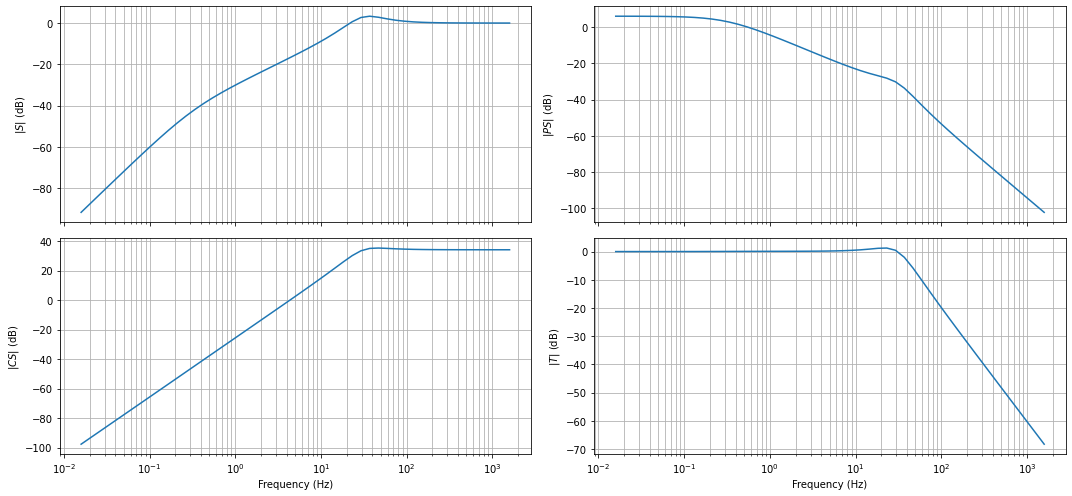

C:\Users\tang8\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:238: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\tang8\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:201: RuntimeWarning: Glyph 8 missing from current font.
  font.set_text(s, 0, flags=flags)


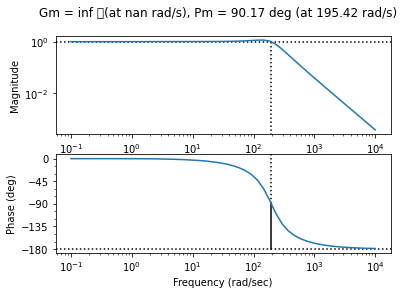

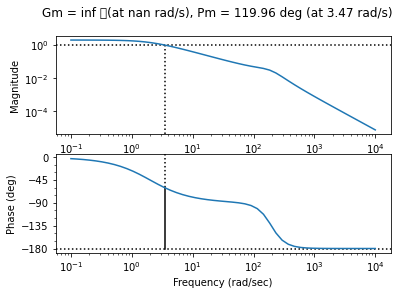

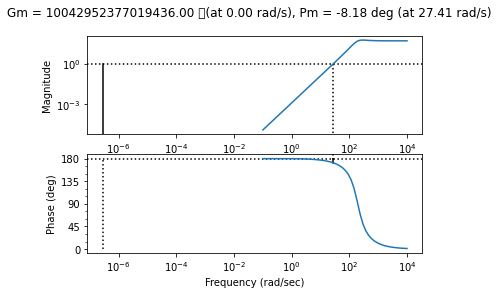

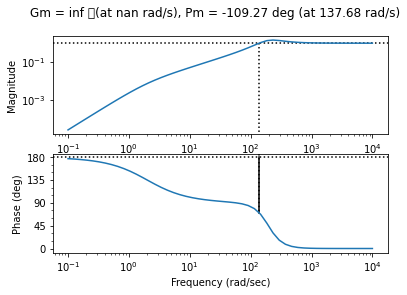

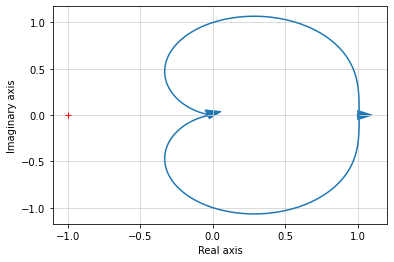

In [218]:
H_elev_to_pitch = 0.5*(s/2*(1/(s/200+1))+1)

plt.figure()
rootlocus(G_elev_to_pitch*H_elev_to_pitch)
plt.plot([0, -1], [0, 1], '--')

Gc_elev_to_pitch = G_elev_to_pitch*H_elev_to_pitch/(1 + G_elev_to_pitch*H_elev_to_pitch)

plt.figure()
step_size = 10
t, y = control.step_response(step_size*Gc_elev_to_pitch, T=np.linspace(0, 1, 1000));
plt.plot(t, y)
plt.ylabel('pitch, deg')
plt.xlabel('t, sec')
plt.title('output')

plt.figure()
# actual error was computed in radians, so, converting back here
e = np.deg2rad(step_size-y)
t, u, _= control.forced_response(H_elev_to_pitch, T=t, U=e)
plt.plot(t, u)
plt.hlines([-1, 1], t[0], t[-1], linestyles='dashed')
plt.title('input')
plt.ylabel('elevator, norm')
plt.xlabel('t, sec')

plt.figure(figsize=(15, 7))
control.gangof4(G_elev_to_pitch, H_elev_to_pitch, Hz=True, dB=True)

#plt.figure()
#control.bode_plot(G_elev_to_pitch*H_elev_to_pitch,margins=True)

plt.figure()
control.bode_plot(G_elev_to_pitch*H_elev_to_pitch/(1+G_elev_to_pitch*H_elev_to_pitch),margins=True)

plt.figure()
control.bode_plot(G_elev_to_pitch/(1+G_elev_to_pitch*H_elev_to_pitch),margins=True)

plt.figure()
control.bode_plot(H_elev_to_pitch/(1+G_elev_to_pitch*H_elev_to_pitch),margins=True)

plt.figure()
control.bode_plot(1/(1+G_elev_to_pitch*H_elev_to_pitch),margins=True)

plt.figure()
control.nyquist(Gc_elev_to_pitch, omega=np.logspace(-3, 3, 1000));

control.margin(Gc_elev_to_pitch)

### Roll

In [237]:
sys = control.ss(*linearize(
    aircraft='F-35B-2',
    states=['ic/p-rad_sec'],
    states_deriv = ['accelerations/pdot-rad_sec2'],
    inputs=['fcs/aileron-cmd-norm'],
    outputs=['ic/p-rad_sec'],
    ic=op_cruise,
    dx=1e-3,
    n_round=3
))
rad2deg = 180/np.pi
s = control.tf([1, 0], [1])
G_aileron_to_roll = rad2deg*clean_tf(control.minreal(control.ss2tf(sys), 1e-3))/s
G_aileron_to_roll

0 states have been removed from the model


TransferFunction(array([6386.8178381]), array([1., 0., 0.]))

In [234]:
sys

StateSpace(array([], shape=(0, 0), dtype=float64), array([], shape=(0, 1), dtype=float64), array([], shape=(1, 0), dtype=float64), array([[0.]]))

C:\Users\tang8\anaconda3\lib\site-packages\control\freqplot.py:673: RuntimeWarning: divide by zero encountered in log10
  plot_axes['ps'].semilogx(omega_plot, 20 * np.log10(mag), **kwargs)
C:\Users\tang8\anaconda3\lib\site-packages\control\freqplot.py:694: RuntimeWarning: divide by zero encountered in log10
  plot_axes['t'].semilogx(omega_plot, 20 * np.log10(mag), **kwargs)


(inf, inf, nan, nan)

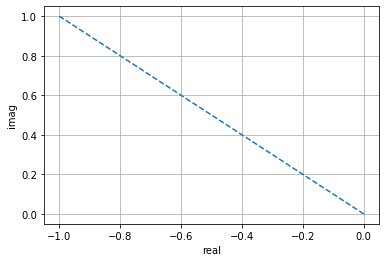

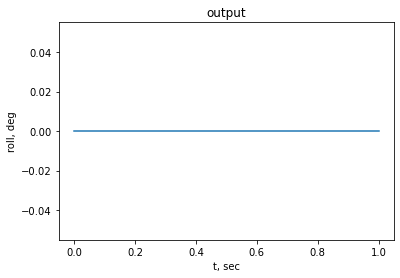

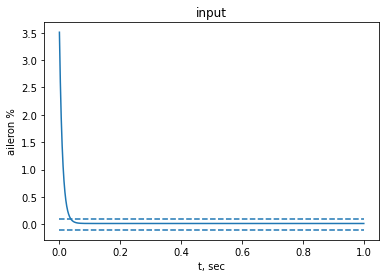

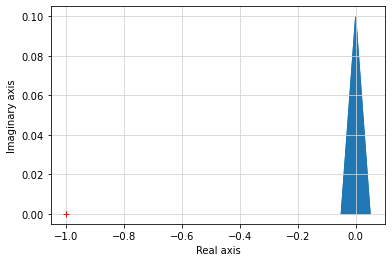

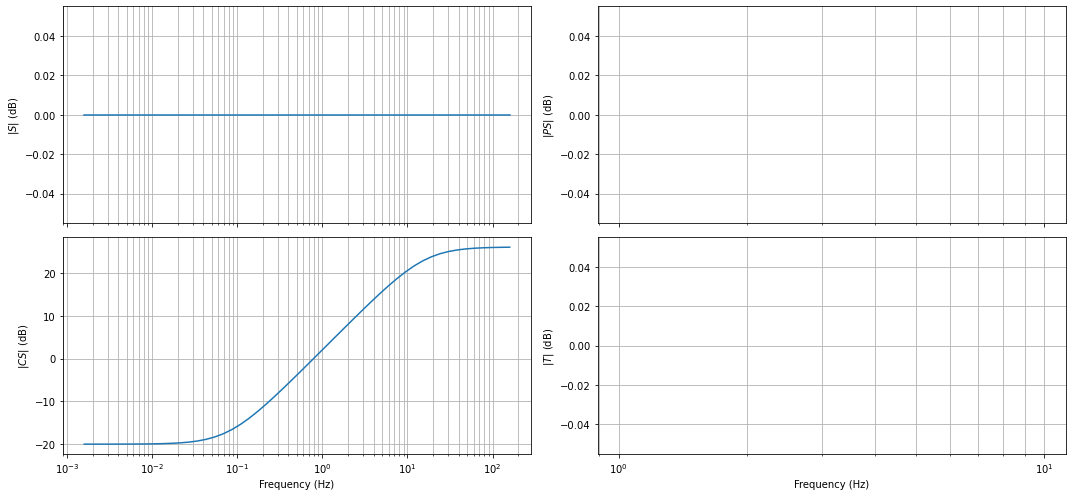

In [221]:
H_aileron_to_roll = 0.1*(s/0.5*1/(s/100+1) + 1)

plt.figure()
rootlocus(G_aileron_to_roll*H_aileron_to_roll)
plt.plot([0, -1], [0, 1], '--')

Gc_aileron_to_roll  = G_aileron_to_roll*H_aileron_to_roll/(1 + G_aileron_to_roll*H_aileron_to_roll)


plt.figure()
step_size = 10
t, y = control.step_response(step_size*Gc_aileron_to_roll, T=np.linspace(0, 1, 1000));
plt.plot(t, y)
plt.xlabel('t, sec')
plt.ylabel('roll, deg')
plt.title('output')

plt.figure()
# actual error was computed in radians, so, converting back here
e = np.deg2rad(step_size-y)
t, u, _= control.forced_response(H_aileron_to_roll, T=t, U=e)
plt.hlines([-0.1, 0.1], t[0], t[-1], linestyles='dashed')
plt.plot(t, u)
plt.xlabel('t, sec')
plt.ylabel('aileron %')
plt.title('input')

plt.figure()
control.nyquist(Gc_aileron_to_roll, omega=np.logspace(-3, 3, 1000));

plt.figure(figsize=(15, 7))
control.gangof4(G_aileron_to_roll, H_aileron_to_roll, Hz=True, dB=True)

control.margin(Gc_aileron_to_roll)

## Yaw

In [193]:
sys = control.ss(*linearize(
    aircraft='F-35B-2',
    states=['ic/r-rad_sec'],
    states_deriv = ['accelerations/rdot-rad_sec2'],
    inputs=['propulsion/engine/yaw-angle-rad'],
    outputs=['ic/r-rad_sec'],
    ic=op_hover,
    dx=1e-3,
    n_round=3
))
s = control.tf([1, 0], [1])
G_rudder_to_yaw = -clean_tf(control.minreal(control.ss2tf(sys), 1e-3))/s
G_rudder_to_yaw

0 states have been removed from the model


TransferFunction(array([0.]), array([1.]))

Yaw angle seems to have no impact on r moment, need to investigate. Can add another lift-fan to model this if necessary.

## Altitude

In [227]:
sys = control.ss(*linearize(
    aircraft='F-35B-2',
    states=['ic/w-fps'],
    states_deriv = ['accelerations/wdot-ft_sec2'],
    inputs=['fcs/throttle-cmd-norm'],
    outputs=['ic/w-fps'],
    ic=op_hover,
    dx=1e-3,
    n_round=3
))
G_throttle_to_alt = -clean_tf(control.minreal(control.ss2tf(sys), 1e-3))/s
G_throttle_to_alt

0 states have been removed from the model


TransferFunction(array([85.502]), array([1., 0., 0.]))

C:\Users\tang8\anaconda3\lib\site-packages\control\margins.py:322: RuntimeWarning: invalid value encountered in less_equal
  w_180 = w_180[w180_resp <= 0.]
C:\Users\tang8\anaconda3\lib\site-packages\control\margins.py:323: RuntimeWarning: invalid value encountered in less_equal
  w180_resp = w180_resp[w180_resp <= 0.]


(inf, 98.91488925474505, nan, 1.4332671517250204)

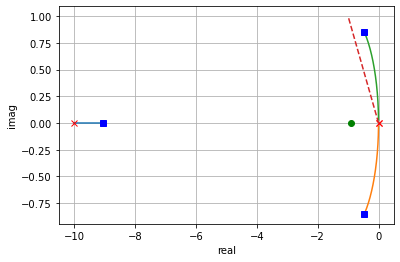

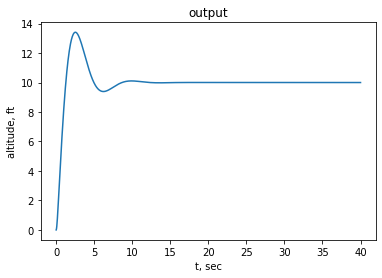

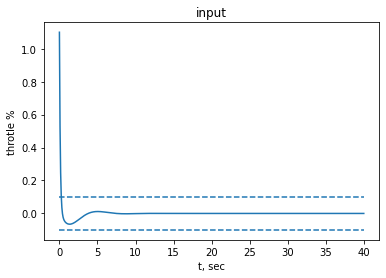

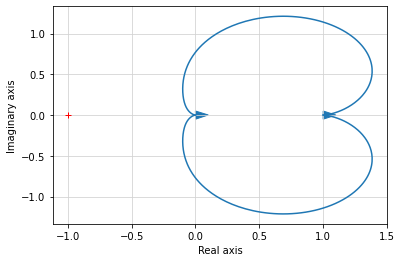

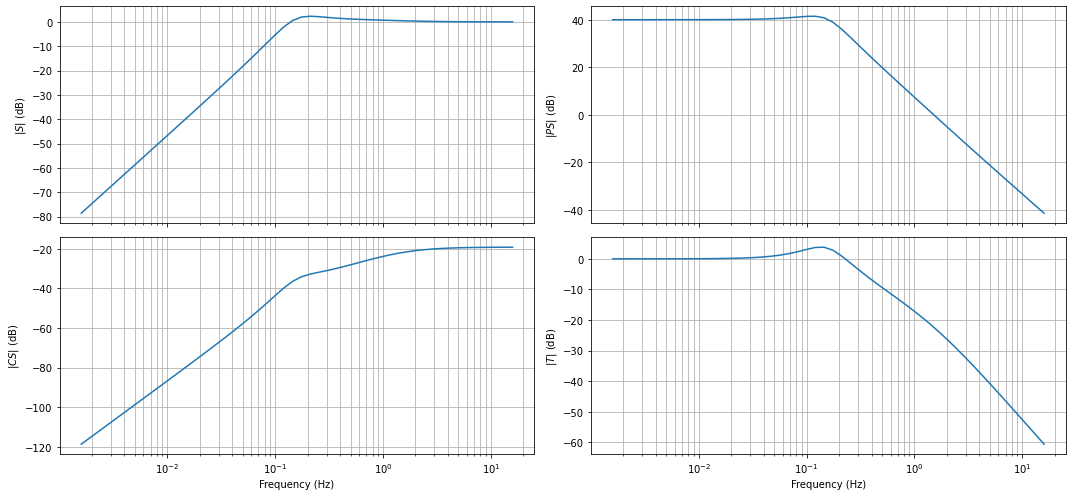

In [232]:
H_throttle_to_alt = 0.01*(2*s*0.5/(s/10+1) + 1)


plt.figure()
rootlocus(G_throttle_to_alt*H_throttle_to_alt)
plt.plot([0, -1], [0, 1], '--')

Gc_throttle_to_alt = G_throttle_to_alt*H_throttle_to_alt/(1 + G_throttle_to_alt*H_throttle_to_alt)

plt.figure()
step_size = 10
t, y = control.step_response(step_size*Gc_throttle_to_alt, T=np.linspace(0, 40, 1000));
plt.plot(t, y)
plt.xlabel('t, sec')
plt.ylabel('altitude, ft')
plt.title('output')

plt.figure()
# error computed in ft
e = step_size-y
t, u, _= control.forced_response(H_throttle_to_alt, T=t, U=e)
plt.hlines([-0.1, 0.1], t[0], t[-1], linestyles='dashed')
plt.plot(t, u)
plt.xlabel('t, sec')
plt.ylabel('throtle %')
plt.title('input')

plt.figure()
control.nyquist(Gc_throttle_to_alt, omega=np.logspace(-3, 3, 1000));

plt.figure(figsize=(15, 7))
control.gangof4(G_throttle_to_alt, H_throttle_to_alt, Hz=True, dB=True)

control.margin(Gc_throttle_to_alt)